In [9]:
import csv
import pandas as pd

In [10]:
extract = pd.read_csv("egcut_epi_nesma_extracted_features_example.csv",header=None)

In [11]:
extract.columns = ["text_ID","start","end","object","value","unit","min","max"]

In [12]:
text = pd.read_csv("egcut_epi_nesma_texts_example.csv",header=None)

In [13]:
text.columns = ["text_ID","text"]
text.head()

,text_ID,text
0,347474,\nRR 132/84 \n\n
1,46809,RR 130/80 mmHg.
2,45389,"Kergelt liigkaaluline. Nahk, limaskestad taval..."
3,47482,"RR142/89mmHg, HR 76 x min, p167cm, k89kg. EKG..."
4,53393,"RR143/87mmHg, HR60 x min, p180cm, k93kg"


In [14]:
text.text_ID.value_counts()

428132     61
440167     31
284004     28
179052     28
1118428    25
           ..
1644002     1
356033      1
539481      1
429757      1
804663      1
Name: text_ID, Length: 121535, dtype: int64

In [15]:
text = text.drop_duplicates(subset='text_ID', keep='first')

In [16]:
DS = pd.merge(extract, text, how="left", on='text_ID')

In [1]:
#from estnltk import Text

In [12]:
#DS.to_csv("MergedDS.csv",index=False)

In [17]:
X = DS.text
Y = DS.object
Z = DS.value
Span = DS[["start","end"]]
X = X[:5000]
Span = Span[:5000] 
Y = Y[:5000]
Z = Z[:5000]

In [18]:
max_sent_len = max([len(sentence) for sentence in DS.text])


In [28]:
max_sent_len

102602

In [19]:
import numpy as np
from keras.utils import np_utils

import matplotlib.pyplot as plt
from keras.layers import GRU,Dropout,BatchNormalization
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer

%matplotlib inline

Using TensorFlow backend.


In [30]:
# def plot_history(history):
#     acc = history.history['accuracy']
#     val_acc = history.history['val_acc']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     x = range(1, len(acc) + 1)

#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(x, acc, 'b', label='Training acc')
#     plt.plot(x, val_acc, 'r', label='Validation acc')
#     plt.title('Training and validation accuracy')
#     plt.legend()
#     plt.subplot(1, 2, 2)
#     plt.plot(x, loss, 'b', label='Training loss')
#     plt.plot(x, val_loss, 'r', label='Validation loss')
#     plt.title('Training and validation loss')
#     plt.legend()

In [20]:
Xtrain, Xtest, Ytrain, Ytest , Ztrain, Ztest ,Strain,Stest = train_test_split(X, Y, Z,Span, test_size=0.2, random_state=1)

Xtrain, Xval, Ytrain, Yval , Ztrain, Zval , Strain, Sval= train_test_split(Xtrain, Ytrain, Ztrain, Strain, test_size=0.25, random_state=1)



In [21]:
shape = 3
encoder = LabelEncoder()
encoder.fit(Y) #3 classes in Object column


Ytrain = encoder.transform(Ytrain)
Ytest = encoder.transform(Ytest)
Yval = encoder.transform(Yval)

Ytrain = np_utils.to_categorical(Ytrain)
Ytest = np_utils.to_categorical(Ytest)
Yval = np_utils.to_categorical(Yval)



In [22]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(Xtrain)

Xtrain = tokenizer.texts_to_sequences(Xtrain)
Xtest = tokenizer.texts_to_sequences(Xtest)
Xval = tokenizer.texts_to_sequences(Xval)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index



In [23]:
maxlen = 100

Xtrain = pad_sequences(Xtrain, padding='post', maxlen=maxlen)
Xtest = pad_sequences(Xtest, padding='post', maxlen=maxlen)
Xval = pad_sequences(Xval, padding='post', maxlen=maxlen)



In [24]:
!pip install keras_contrib


ERROR: Could not find a version that satisfies the requirement keras_contrib (from versions: none)
ERROR: No matching distribution found for keras_contrib


In [25]:
from keras.models import Sequential
from keras import layers
from keras.layers import Input, LSTM, Embedding, Dense
from keras.layers import Bidirectional
model = Sequential()

input_text = keras.layers.Input(shape=(maxlen,),dtype='int32',name="input_text")
emb = Embedding(input_dim=vocab_size, output_dim=256, input_length=maxlen)(input_text)
lstm_out = Bidirectional(keras.layers.LSTM(256))(emb)

# span = keras.layers.Input(shape=(2, ),name="span")
# merged = keras.layers.concatenate([lstm_out,span])
x = keras.layers.Dropout(0.1)(lstm_out)

# x = keras.layers.Dense(128, activation='relu')(lstm_out)
# x = keras.layers.Dense(64, activation='relu')(x)
# x = keras.layers.Dense(32, activation='relu')(x)
output_object = keras.layers.Dense(3, activation='linear',name="output_object")(x)
# from keras_contrib.layers import CRF
# crf = CRF(3)
# output_object = crf(x) 
output_value = keras.layers.Dense(1, activation='linear',name="output_value")(x)


# model = keras.models.Model(inputs=[input_text,span],

model = keras.models.Model(input_text,
                                outputs=[output_object,output_value])
from keras.optimizers import adam 
opt = adam(lr=0.001)
# model.compile(optimizer= "adam" ,loss=[ "categorical_crossentropy","mean_squared_logarithmic_error"],metrics=['accuracy',"mse"])
model.compile(optimizer= opt ,loss= {'output_object':"categorical_crossentropy",'output_value':"mean_squared_logarithmic_error"}, metrics={'output_object': 'accuracy','output_value': "mse"})
              #,metrics=['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 256)     9718272     input_text[0][0]                 
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 512)          1050624     embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512)          0           bidirectional_1[0][0]            
____________________________________________________________________________________________

In [26]:
# tryx = Xtrain.reshape((3000,100))
# history = model.fit([tryx,Strain], y = [Ytrain,Ztrain],

# keras.callbacks.EarlyStopping(monitor='val_loss',
#                               min_delta=0,
#                               patience=2,
#                               verbose=0, mode='auto')

history = model.fit(Xtrain, y = [Ytrain,Ztrain],
                    epochs=10,
                    verbose=True,
#                     validation_data=([Xval,Sval], [Yval,  Zval]),batch_size=1000)
                    validation_data=(Xval, [Yval,  Zval]),batch_size=1000)

#,batch_size=5000


C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3000 samples, validate on 1000 samples
Epoch 1/10
3000/3000 [==============================] - 20s 7ms/step - loss: 25.2281 - output_object_loss: 3.1147 - output_value_loss: 22.1134 - output_object_accuracy: 0.3720 - output_value_mse: 10468719.0000 - val_loss: 23.3176 - val_output_object_loss: 1.4157 - val_output_value_loss: 21.9019 - val_output_object_accuracy: 0.1430 - val_output_value_mse: 214523.5938
Epoch 2/10
3000/3000 [==============================] - 20s 7ms/step - loss: 22.9072 - output_object_loss: 1.2524 - output_value_loss: 21.6547 - output_object_accuracy: 0.1323 - output_value_mse: 10468696.0000 - val_loss: 22.2442 - val_output_object_loss: 1.1995 - val_output_value_loss: 21.0447 - val_output_object_accuracy: 0.1370 - val_output_value_mse: 214489.3438
Epoch 3/10
3000/3000 [==============================] - 19s 6ms/step - loss: 21.8979 - output_object_loss: 1.2744 - output_value_loss: 20.6235 - output_object_accuracy: 0.1100 - output_value_mse: 10468609.0000 - va

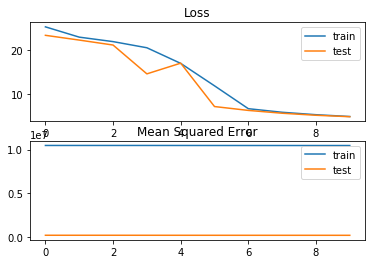

In [29]:
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot mse during training
pyplot.subplot(212)
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['output_value_mse'], label='train')
pyplot.plot(history.history['val_output_value_mse'], label='test')
pyplot.legend()
pyplot.show()

In [30]:
# f= open("report.csv","a")
# loss1, accuracy1,loss2, accuracy2 = 
model.evaluate(Xtrain, [Ytrain,Ztrain], verbose=True)
# print("Training Accuracy: {:.4f}".format(accuracy))
# f.write(",{:.4f}".format(accuracy))

# loss, accuracy = model.evaluate(Xval, Yval, verbose=True)

# print("Validation Accuracy:  {:.4f}".format(accuracy))
# f.write(",{:.4f} \n".format(accuracy))
# f.close()
# plot_history(history)
# Ypred = model.predict(Xtest)
# from sklearn.metrics import confusion_matrix, classification_report

# matrix = confusion_matrix(Ytest.argmax(axis=1), Ypred.argmax(axis=1))
# classification_Report = classification_report(Ytest.argmax(axis=1), Ypred.argmax(axis=1), output_dict=True)
# df = pd.DataFrame(classification_Report).transpose()
# df.to_csv("ClassificationReport.csv")

3000/3000 [==============================] - 22s 7ms/step


[4.782543665568034,
 2.0504844188690186,
 2.729947566986084,
 0.12733332812786102,
 10459574.0]

In [31]:
pred1,pred2 = model.predict(Xval)


In [32]:
model.evaluate(Xtest, [Ytest,Ztest], verbose=True)


1000/1000 [==============================] - 7s 7ms/step


[4.848122142791748,
 2.093463897705078,
 2.746799945831299,
 0.12999999523162842,
 16023612.0]

In [38]:
from keras.models import Sequential
from keras import layers
from keras.layers import Input, LSTM, Embedding, Dense
from keras.layers import Bidirectional
model2 = Sequential()

input_text = keras.layers.Input(shape=(maxlen,),dtype='int32',name="input_text")
emb = Embedding(input_dim=vocab_size, output_dim=256, input_length=maxlen)(input_text)
lstm_out = Bidirectional(keras.layers.LSTM(256))(emb)

# span = keras.layers.Input(shape=(2, ),name="span")
# merged = keras.layers.concatenate([lstm_out,span])

x = keras.layers.Dense(128, activation='relu')(lstm_out)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)

output_object = keras.layers.Dense(3, activation='linear',name="output_object")(x)
# from keras_contrib.layers import CRF
# crf = CRF(3)
# output_object = crf(x) 
output_value = keras.layers.Dense(1, activation='linear',name="output_value")(x)


# model = keras.models.Model(inputs=[input_text,span],

model2 = keras.models.Model(input_text,
                                outputs=[output_object,output_value])
from keras.optimizers import adam 
opt = adam(lr=0.001)
# model.compile(optimizer= "adam" ,loss=[ "categorical_crossentropy","mean_squared_logarithmic_error"],metrics=['accuracy',"mse"])
model2.compile(optimizer= opt ,loss= {'output_object':"categorical_crossentropy",'output_value':"mean_squared_logarithmic_error"}, metrics={'output_object': 'accuracy','output_value': "mse"})
              #,metrics=['accuracy'])

model2.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 256)     9718272     input_text[0][0]                 
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 512)          1050624     embedding_2[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          65664       bidirectional_2[0][0]            
____________________________________________________________________________________________

In [39]:
# tryx = Xtrain.reshape((3000,100))
# history = model.fit([tryx,Strain], y = [Ytrain,Ztrain],

# keras.callbacks.EarlyStopping(monitor='val_loss',
#                               min_delta=0,
#                               patience=2,
#                               verbose=0, mode='auto')

history2 = model2.fit(Xtrain, y = [Ytrain,Ztrain],
                    epochs=10,
                    verbose=True,
#                     validation_data=([Xval,Sval], [Yval,  Zval]),batch_size=1000)
                    validation_data=(Xval, [Yval,  Zval]),batch_size=1000)

#,batch_size=5000


C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3000 samples, validate on 1000 samples
Epoch 1/10
3000/3000 [==============================] - 30s 10ms/step - loss: 28.1943 - output_object_loss: 6.0319 - output_value_loss: 22.1624 - output_object_accuracy: 0.3093 - output_value_mse: 10468722.0000 - val_loss: 25.3448 - val_output_object_loss: 3.2259 - val_output_value_loss: 22.1188 - val_output_object_accuracy: 0.2290 - val_output_value_mse: 214532.1562
Epoch 2/10
3000/3000 [==============================] - 32s 11ms/step - loss: 24.1951 - output_object_loss: 2.1957 - output_value_loss: 21.9994 - output_object_accuracy: 0.2333 - output_value_mse: 10468710.0000 - val_loss: 22.5871 - val_output_object_loss: 0.7297 - val_output_value_loss: 21.8574 - val_output_object_accuracy: 0.1590 - val_output_value_mse: 214523.6094
Epoch 3/10
3000/3000 [==============================] - 35s 12ms/step - loss: 22.3837 - output_object_loss: 0.7259 - output_value_loss: 21.6578 - output_object_accuracy: 0.1493 - output_value_mse: 10468688.0000 -

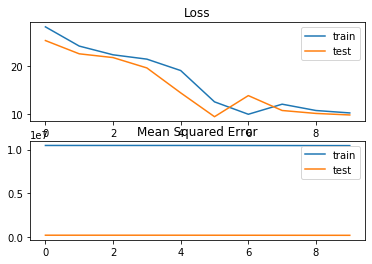

In [40]:
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history2.history['loss'], label='train')
pyplot.plot(history2.history['val_loss'], label='test')
pyplot.legend()
# plot mse during training
pyplot.subplot(212)
pyplot.title('Mean Squared Error')
pyplot.plot(history2.history['output_value_mse'], label='train')
pyplot.plot(history2.history['val_output_value_mse'], label='test')
pyplot.legend()
pyplot.show()

In [41]:
model2.evaluate(Xtrain, [Ytrain,Ztrain], verbose=True)


3000/3000 [==============================] - 34s 11ms/step


[10.091463821411132,
 9.190621376037598,
 0.9032018780708313,
 0.3096666634082794,
 10447953.0]

In [37]:
from tensorflow_addons.text.crf import crf_binary_score